In [1]:
## Import Libraries ##

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(42)
#### Import Libraries ####
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm 
from tensorflow import keras
import os, cv2, json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam

from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D

In [2]:
## Image path ##

train_dir = r"E:\Collage\Selected_2\Selected_2_Project\tomato\train"
test_dir = r"E:\Collage\Selected_2\Selected_2_Project\tomato\val"

In [3]:
## Data Rescaling and augmentation ##

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
    input_shape=(112, 112, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name ="data_augmentation")

In [4]:
## Load datasets (Shuffle and prefetch) ##

import tensorflow as tf

IMG_SIZE = (112, 112)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=42
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = test_data.class_names
valid_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


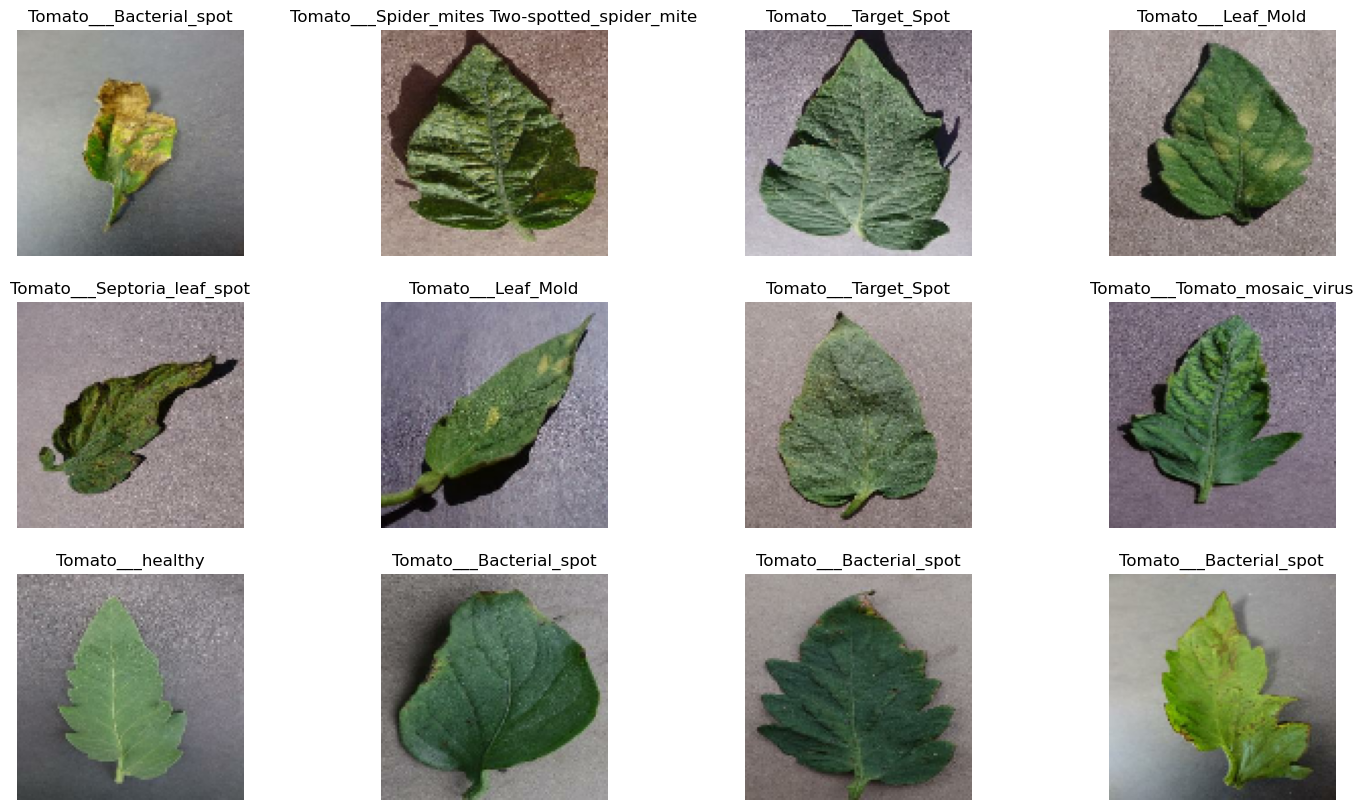

In [5]:
## Visualize data ##

plt.figure(figsize=(18,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

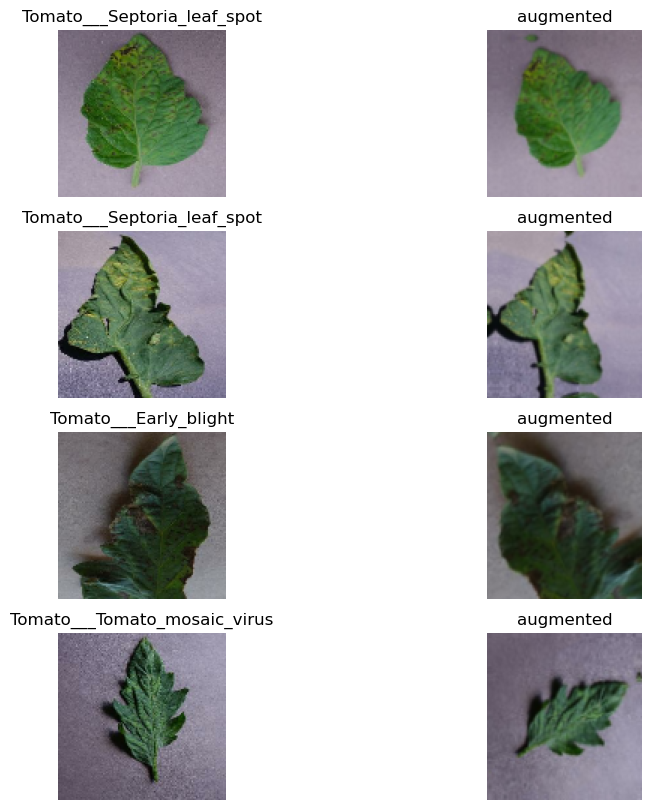

In [6]:
## Augmented image view ##

plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        plt.imshow(augmented_image_batch[i])
        plt.title(f"augmented")
        plt.axis("off")

In [7]:
## Create Checkpoint ##

checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

In [8]:
## Create model ##

import tensorflow as tf

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layers')

])

In [9]:
## Summary ##

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                        

In [10]:
## Compile model ##

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [11]:
## Fit the model ##

history = model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback
    ]
)
## Save model ##

my_model = model
import os
from tensorflow.keras.models import save_model

def save_keras_model(model, model_name, subject, acc, save_path='models'):
    # Create the save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
  
    # Format the save ID string
    save_id = f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.h5'
  
    # Join the save path and the save ID to get the full file path
    model_save_loc = os.path.join(save_path, save_id)
  
    # Save the model to disk
    save_model(model, model_save_loc)
  
    print(f'Saved model to {model_save_loc}')

Epoch 1/100
313/313 [==============================] - 52s 162ms/step - loss: 2.1047 - accuracy: 0.2186 - val_loss: 1.8243 - val_accuracy: 0.4010
Epoch 2/100
313/313 [==============================] - 49s 157ms/step - loss: 1.6771 - accuracy: 0.4195 - val_loss: 1.5491 - val_accuracy: 0.4360
Epoch 3/100
313/313 [==============================] - 50s 160ms/step - loss: 1.3945 - accuracy: 0.5087 - val_loss: 1.3441 - val_accuracy: 0.5130
Epoch 4/100
313/313 [==============================] - 51s 164ms/step - loss: 1.2298 - accuracy: 0.5697 - val_loss: 1.1238 - val_accuracy: 0.6040
Epoch 5/100
313/313 [==============================] - 51s 162ms/step - loss: 1.1209 - accuracy: 0.6044 - val_loss: 1.1159 - val_accuracy: 0.5920
Epoch 6/100
313/313 [==============================] - 42s 134ms/step - loss: 1.0080 - accuracy: 0.6460 - val_loss: 0.9217 - val_accuracy: 0.6850
Epoch 7/100
313/313 [==============================] - 38s 121ms/step - loss: 0.9467 - accuracy: 0.6707 - val_loss: 0.8698 -

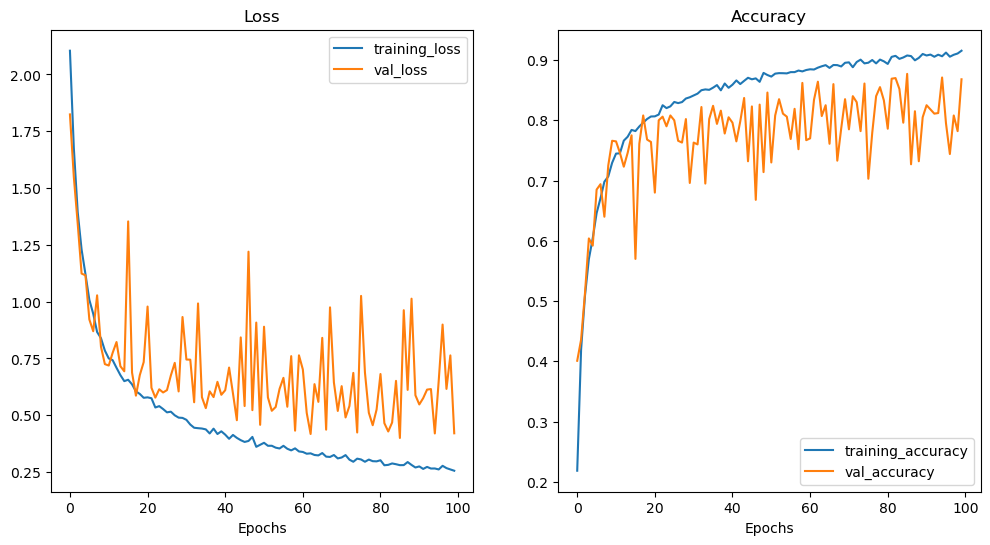

In [12]:
## Create plot_loss_curve function ##

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

## plot the model ##    
    
plot_loss_curves(history)

In [13]:
## Evaluate model ##

model.evaluate(test_data)

32/32 [==============================] - 1s 27ms/step - loss: 0.4206 - accuracy: 0.8680


[0.4206331670284271, 0.8679999709129333]

In [14]:
## Evaluate best model ##
## Load the best weight ##

model.load_weights(checkpoint_path)

In [15]:
## Evaluate ##

model.evaluate(train_data), model.evaluate(test_data)

32/32 [==============================] - 1s 26ms/step - loss: 0.4001 - accuracy: 0.8770


([0.32966986298561096, 0.8888999819755554],
 [0.40007269382476807, 0.8769999742507935])

In [16]:
## Load pretrain model ##
## Download pre train model ##

import urllib.request

url = "https://github.com/HSAkash/Tomato-leaf-disease/raw/main/pretrain_model.h5"
filename = "pretrain_model.h5"

urllib.request.urlretrieve(url, filename)


('pretrain_model.h5', <http.client.HTTPMessage at 0x1a5bf6afeb0>)

In [17]:
## Laod model ##

load_model = tf.keras.models.load_model("pretrain_model.h5")

In [18]:
## summary of load data ##

load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                        

In [19]:
## Evaluate load model with valid data or test_data ##

load_model.evaluate(train_data),load_model.evaluate(test_data)

32/32 [==============================] - 1s 27ms/step - loss: 0.0776 - accuracy: 0.9820


([0.03175170347094536, 0.9904999732971191],
 [0.07763728499412537, 0.9819999933242798])

1/1 [==============================] - 0s 266ms/step


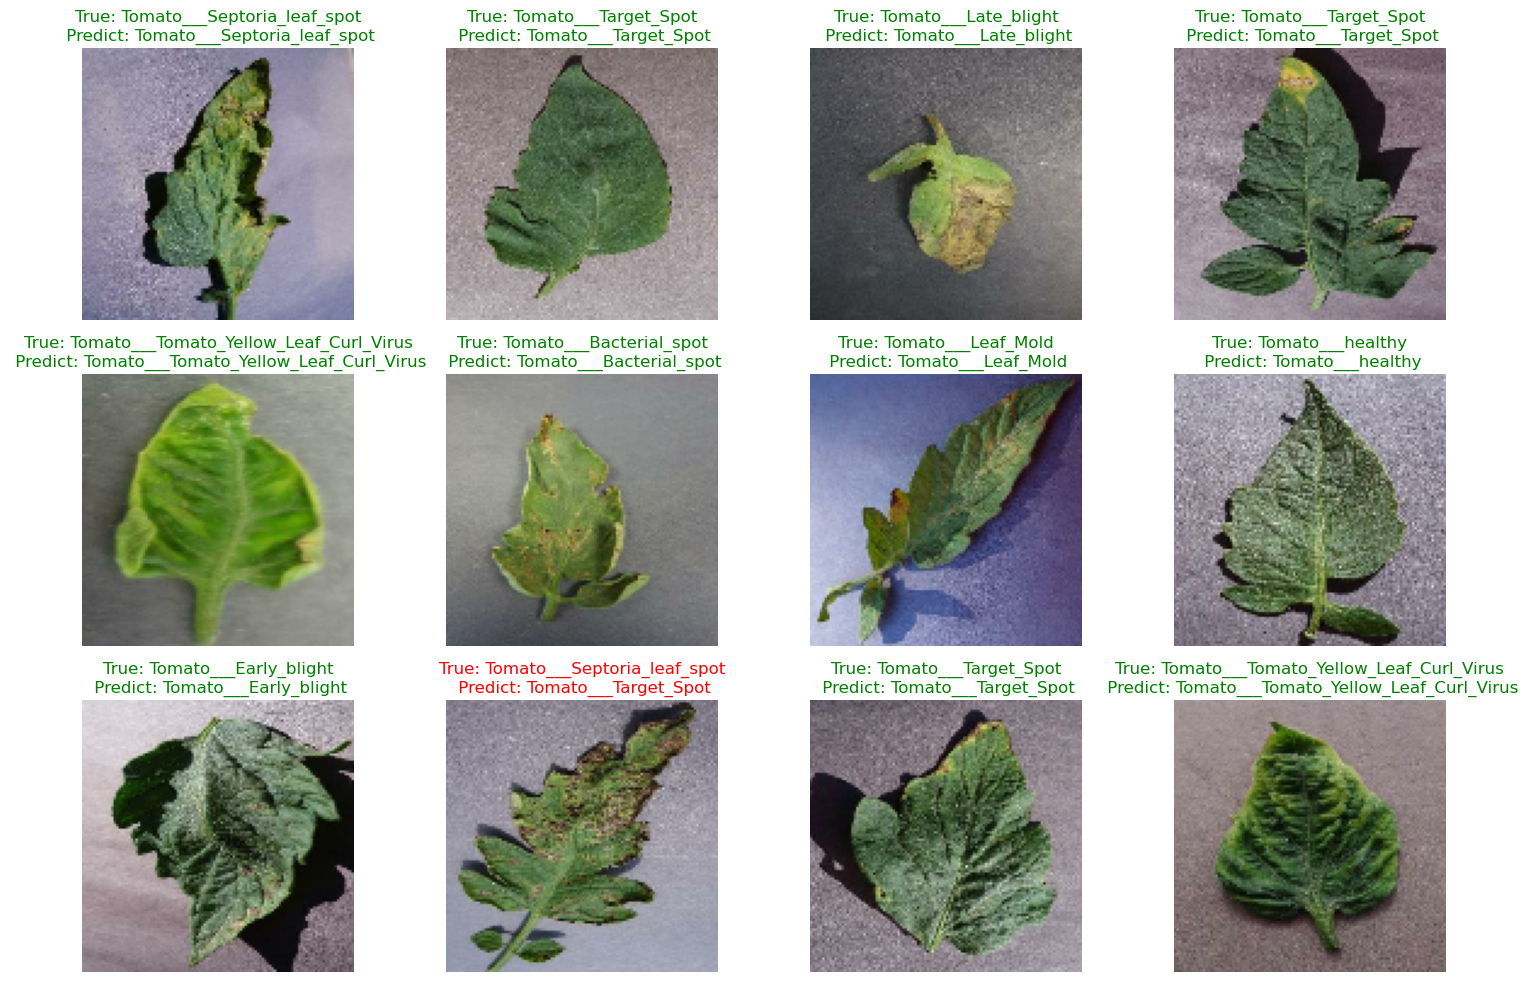

In [20]:
## Prediction && visualize ##

plt.figure(figsize=(18,12))
for image_batch,label_batch in test_data.take(1):
    predictions = load_model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")

In [21]:
## Confusion matrix ##

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels,
         )
  
  # Make x-axis labels appear on bottom
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

In [22]:
## Predict y_pred and get y_true ##

y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(load_model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 0s 56ms/step


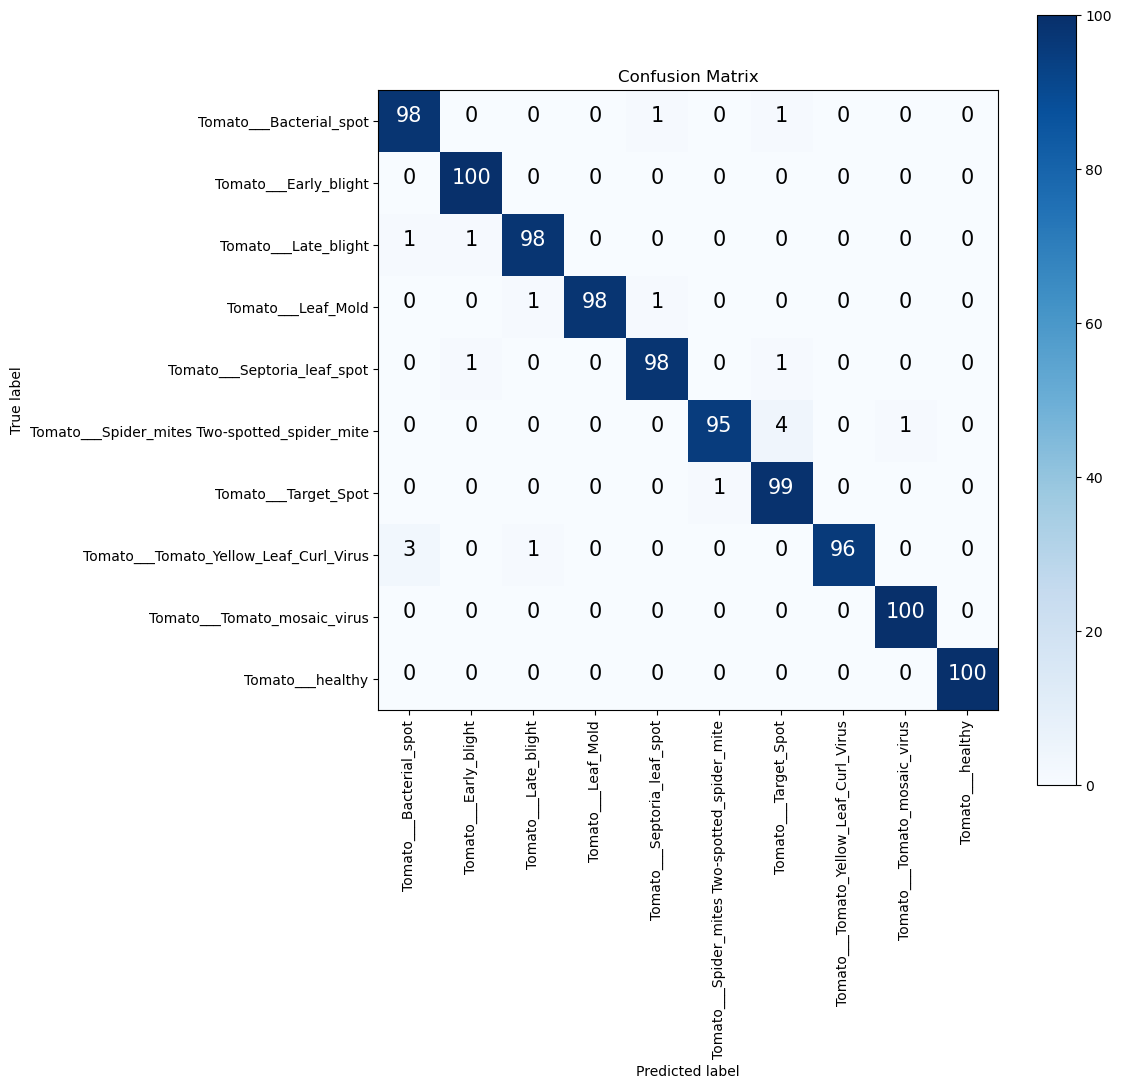

In [23]:
## Plot confusion matrix ##

make_confusion_matrix(y_true, y_pred, class_names)